Beats per Minute Prediction Competition on Kaggle


In [1]:
#Import libraries

import pandas as pd
import numpy as np 

In [2]:
#Import the data

sample_submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
print(train.shape)
print(train.columns)
print(train.head())
print(train.info())

(524164, 11)
Index(['id', 'RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy', 'BeatsPerMinute'],
      dtype='object')
   id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717               

Using my knowledge of music, I know that the key to BPM is sitting somewhere in the Rhythm score as that is the group charged with establishing timing for the song.

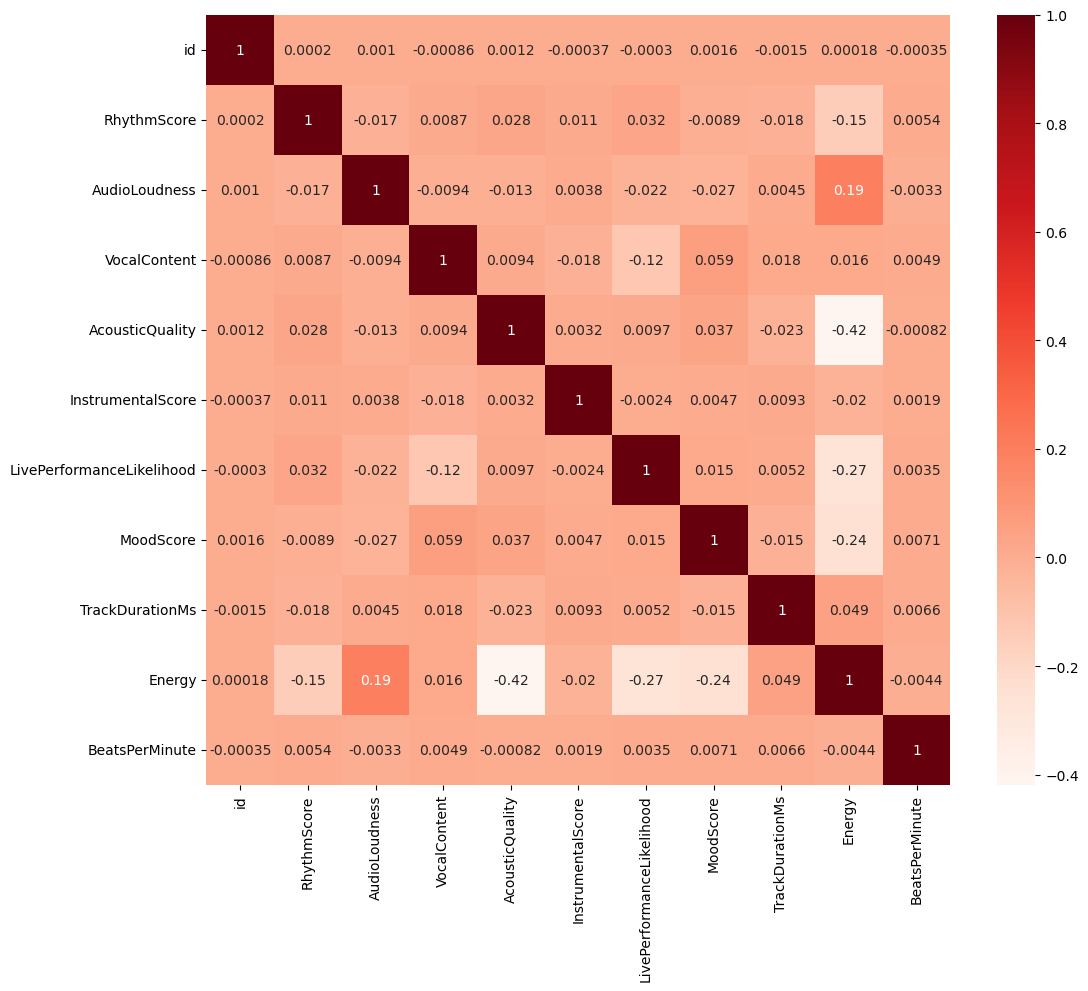

In [4]:
#Chreate a heatmap to see correlations against BeatsPerMinute

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see that rhythm score has the most noticiable correlation with the overall BPM for the songs along. The rest of the features appear to to weak correlation but none is strong enough or weak enough to remove from the model. 

In [ ]:
# Install required packages for gradient boosting models and hyperparameter tuning
import subprocess
import sys

packages = ['xgboost', 'lightgbm', 'catboost', 'optuna', 'scikit-learn']
for package in packages:
    try:
        __import__(package)
        print(f"{package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
# Import required libraries for modeling
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Prepare the data for modeling
# Separate features and target
X = train.drop(['id', 'BeatsPerMinute'], axis=1)
y = train['BeatsPerMinute']
X_test = test.drop(['id'], axis=1)

# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target stats - Mean: {y.mean():.2f}, Std: {y.std():.2f}, Min: {y.min():.2f}, Max: {y.max():.2f}")

## XGBoost Model with Optuna Hyperparameter Tuning

In [ ]:
# XGBoost with Optuna hyperparameter tuning
def objective_xgb(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting XGBoost hyperparameter optimization...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

print(f"Best RMSE: {study_xgb.best_value:.4f}")
print(f"Best parameters: {study_xgb.best_params}")

# Train final XGBoost model with best parameters
best_xgb = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train)

# Evaluate on validation set
xgb_pred_val = best_xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred_val))
xgb_mae = mean_absolute_error(y_val, xgb_pred_val)
xgb_r2 = r2_score(y_val, xgb_pred_val)

print(f"\nXGBoost Validation Results:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R²: {xgb_r2:.4f}")

## LightGBM Model with Optuna Hyperparameter Tuning

In [ ]:
# LightGBM with Optuna hyperparameter tuning
def objective_lgb(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Create and train model
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting LightGBM hyperparameter optimization...")
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)

print(f"Best RMSE: {study_lgb.best_value:.4f}")
print(f"Best parameters: {study_lgb.best_params}")

# Train final LightGBM model with best parameters
best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42, n_jobs=-1, verbose=-1)
best_lgb.fit(X_train, y_train)

# Evaluate on validation set
lgb_pred_val = best_lgb.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred_val))
lgb_mae = mean_absolute_error(y_val, lgb_pred_val)
lgb_r2 = r2_score(y_val, lgb_pred_val)

print(f"\nLightGBM Validation Results:")
print(f"RMSE: {lgb_rmse:.4f}")
print(f"MAE: {lgb_mae:.4f}")
print(f"R²: {lgb_r2:.4f}")

## CatBoost Model with Optuna Hyperparameter Tuning

In [ ]:
# CatBoost with Optuna hyperparameter tuning
def objective_cat(trial):
    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_seed': 42,
        'verbose': False
    }
    
    # Create and train model
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and calculate score
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Run optimization
print("Starting CatBoost hyperparameter optimization...")
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=50)

print(f"Best RMSE: {study_cat.best_value:.4f}")
print(f"Best parameters: {study_cat.best_params}")

# Train final CatBoost model with best parameters
best_cat = cb.CatBoostRegressor(**study_cat.best_params, random_seed=42, verbose=False)
best_cat.fit(X_train, y_train)

# Evaluate on validation set
cat_pred_val = best_cat.predict(X_val)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_pred_val))
cat_mae = mean_absolute_error(y_val, cat_pred_val)
cat_r2 = r2_score(y_val, cat_pred_val)

print(f"\nCatBoost Validation Results:")
print(f"RMSE: {cat_rmse:.4f}")
print(f"MAE: {cat_mae:.4f}")
print(f"R²: {cat_r2:.4f}")

## Model Comparison and Ensemble

In [ ]:
# Compare all models
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'RMSE': [xgb_rmse, lgb_rmse, cat_rmse],
    'MAE': [xgb_mae, lgb_mae, cat_mae],
    'R²': [xgb_r2, lgb_r2, cat_r2]
})

print("Model Comparison:")
print(results_df.round(4))

# Find best model
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest single model: {best_model_name}")

# Create ensemble predictions (simple average)
ensemble_pred_val = (xgb_pred_val + lgb_pred_val + cat_pred_val) / 3
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred_val))
ensemble_mae = mean_absolute_error(y_val, ensemble_pred_val)
ensemble_r2 = r2_score(y_val, ensemble_pred_val)

print(f"\nEnsemble Model Results:")
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R²: {ensemble_r2:.4f}")

# Add ensemble to comparison
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': ['Ensemble'],
    'RMSE': [ensemble_rmse],
    'MAE': [ensemble_mae],
    'R²': [ensemble_r2]
})], ignore_index=True)

print("\nFinal Model Comparison (including ensemble):")
print(results_df.round(4))

In [ ]:
# Feature importance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost feature importance
xgb_importance = best_xgb.feature_importances_
axes[0].barh(X.columns, xgb_importance)
axes[0].set_title('XGBoost Feature Importance')
axes[0].set_xlabel('Importance')

# LightGBM feature importance
lgb_importance = best_lgb.feature_importances_
axes[1].barh(X.columns, lgb_importance)
axes[1].set_title('LightGBM Feature Importance')
axes[1].set_xlabel('Importance')

# CatBoost feature importance
cat_importance = best_cat.feature_importances_
axes[2].barh(X.columns, cat_importance)
axes[2].set_title('CatBoost Feature Importance')
axes[2].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Average feature importance across all models
avg_importance = (xgb_importance + lgb_importance + cat_importance) / 3
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost': xgb_importance,
    'LightGBM': lgb_importance,
    'CatBoost': cat_importance,
    'Average': avg_importance
}).sort_values('Average', ascending=False)

print("Feature Importance Summary:")
print(feature_importance_df.round(4))

## Generate Test Predictions

In [ ]:
# Generate predictions on test set
xgb_test_pred = best_xgb.predict(X_test)
lgb_test_pred = best_lgb.predict(X_test)
cat_test_pred = best_cat.predict(X_test)
ensemble_test_pred = (xgb_test_pred + lgb_test_pred + cat_test_pred) / 3

# Create submission files for each model
submission_xgb = sample_submission.copy()
submission_xgb['BeatsPerMinute'] = xgb_test_pred

submission_lgb = sample_submission.copy()
submission_lgb['BeatsPerMinute'] = lgb_test_pred

submission_cat = sample_submission.copy()
submission_cat['BeatsPerMinute'] = cat_test_pred

submission_ensemble = sample_submission.copy()
submission_ensemble['BeatsPerMinute'] = ensemble_test_pred

# Save submission files
submission_xgb.to_csv('submission_xgboost.csv', index=False)
submission_lgb.to_csv('submission_lightgbm.csv', index=False)
submission_cat.to_csv('submission_catboost.csv', index=False)
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print("Submission files created:")
print("- submission_xgboost.csv")
print("- submission_lightgbm.csv")
print("- submission_catboost.csv")
print("- submission_ensemble.csv")

print(f"\nTest prediction statistics:")
print(f"XGBoost - Mean: {xgb_test_pred.mean():.2f}, Std: {xgb_test_pred.std():.2f}")
print(f"LightGBM - Mean: {lgb_test_pred.mean():.2f}, Std: {lgb_test_pred.std():.2f}")
print(f"CatBoost - Mean: {cat_test_pred.mean():.2f}, Std: {cat_test_pred.std():.2f}")
print(f"Ensemble - Mean: {ensemble_test_pred.mean():.2f}, Std: {ensemble_test_pred.std():.2f}")

# Display first few predictions
print(f"\nFirst 10 predictions comparison:")
comparison_df = pd.DataFrame({
    'ID': test['id'][:10],
    'XGBoost': xgb_test_pred[:10],
    'LightGBM': lgb_test_pred[:10],
    'CatBoost': cat_test_pred[:10],
    'Ensemble': ensemble_test_pred[:10]
})
print(comparison_df.round(2))